In [23]:
from fastai2.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [24]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [25]:
DATA_PATH = Path.cwd()/'data'

In [26]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2,3])

In [27]:
train_tl = TfmdLists(range(5000), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [14]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=32,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [15]:
loss_func = StackLoss(MSELossFlat())

Left: Input, Right: Target

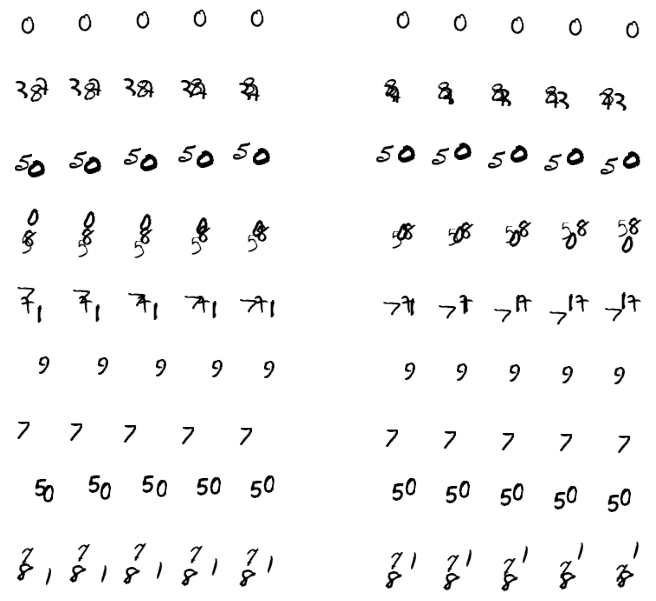

In [16]:
dls.show_batch()

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [40]:
model = StackUnstack(SimpleModel(szs=[16, 32, 64, 128, 128], act=partial(nn.LeakyReLU, 0.2, inplace=True), strategy='encoder'))

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [42]:
learn = Learner(dls, model, loss_func=loss_func, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

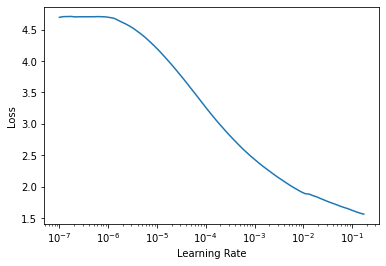

In [39]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,time
0,0.927593,0.638863,00:38
1,0.557288,0.494698,00:38
2,0.477671,0.469669,00:38
3,0.433736,0.436974,00:38
4,0.400843,0.368768,00:38
5,0.371551,0.370477,00:38
6,0.349454,0.306484,00:38
7,0.328590,0.312620,00:38
8,0.317255,0.326444,00:38
9,0.316578,0.291818,00:38


In [44]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [45]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [46]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

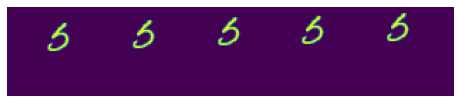

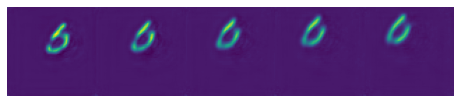

In [47]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)

## A bigger Decoder

We will pass:
- `blur`: to use blur on the upsampling path (this is done by using and a poolling layer and a replication)
- `attn`: to include a self attention layer on the decoder

In [18]:
model2 = StackUnstack(SimpleModel(szs=[16,32, 64 ,128, 128], act=partial(nn.LeakyReLU, 0.2, inplace=True),blur=True, attn=True, strategy='zero'))

We have to reduce batch size as the self attention layer is heavy.

In [19]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=16,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [20]:
learn2 = Learner(dls, model2, loss_func=loss_func, cbs=[]).to_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

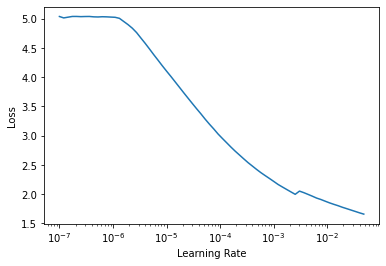

In [16]:
learn2.lr_find()

In [21]:
learn2.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,time
0,0.627909,0.550128,01:38
1,0.499502,0.485055,01:38
2,0.420700,0.412036,01:38
3,0.383649,0.368430,01:38
4,0.352031,0.339804,01:38
5,0.321742,0.308409,01:38
6,0.300550,0.279844,01:38
7,0.284204,0.264077,01:38
8,0.277982,0.268655,01:38
9,0.266469,0.285236,01:38


In [23]:
p,t = learn2.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [24]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [25]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

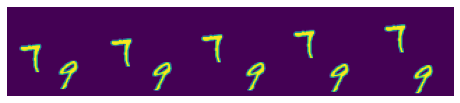

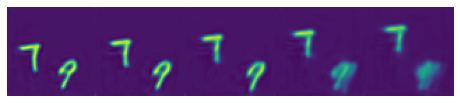

In [37]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)